## Classification using VAE latent space

In [1]:
import collections
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


import vae_lib.utils.nn_logger as log
from vae_lib.nn.simple_nn import SimpleNN
from vae_lib.nn.stochastic_nn_with_gmm import StochasticNNWithGmm
from vae_lib.graphics.plot_utils import plot_2d_latent_space
from vae_lib.graphics.plot_utils import plot_many_images
from vae_lib.preprocessing.data_permutation import permute
from vae_lib.utils.static_gmm_on_circle import StaticGmmOnCircle
from vae_lib.preprocessing.load_reuters import load_reuters
from vae_lib.preprocessing.load_poliblog import load_poliblog
from vae_lib.preprocessing.load_smsspam import load_smsspam

from vae_lib.preprocessing.load_mnist import load_mnist
from vae_lib.nn.dense_layer import DenseLayer
from vae_lib.utils.dynamic_gmm_on_circle import DynamicGmmOnCircle
from vae_lib.utils.mixture_assignments import create_mixture_assignments
from vae_lib.utils.measures import accuracy_for_score
from vae_lib.utils.measures import classification_ratio
from vae_lib.utils.measures import calculate_accuracy_np
from vae_lib.nn.vae_svae_standard import StandardVaeSvae


Normal = tf.distributions.Normal
Bernoulli = tf.distributions.Bernoulli

In [2]:
mnist_train_perm, mnist_test, mnist_labels_train_perm, mnist_labels_test_perm, mnist_onehot_encoder = load_mnist()

In [3]:
reuters_base_path = "/Users/mjankowski/doc/data/reuters/for_python/"
reuters2_data_train_perm, reuters2_data_test, reuters2_labels_train_one_hot_perm, reuters2_labels_test_one_hot, reuters2_onehot_encoder = load_reuters(base_path=reuters_base_path, n_classes=2)
reuters2_data_train_perm.shape, reuters2_data_test.shape, reuters2_labels_train_one_hot_perm.shape, reuters2_labels_test_one_hot.shape



((1064, 2000), (708, 2000), (1064, 2), (708, 2))

In [4]:
reuters_base_path = "/Users/mjankowski/doc/data/reuters/for_python/"
reuters3_data_train_perm, reuters3_data_test, reuters3_labels_train_one_hot_perm, reuters3_labels_test_one_hot, reuters3_onehot_encoder = load_reuters(base_path=reuters_base_path, n_classes=3)
reuters3_data_train_perm.shape, reuters3_data_test.shape, reuters3_labels_train_one_hot_perm.shape, reuters3_labels_test_one_hot.shape



((1655, 2000), (1102, 2000), (1655, 3), (1102, 3))

In [5]:
reuters_base_path = "/Users/mjankowski/doc/data/reuters/for_python/"
reuters5_data_train_perm, reuters5_data_test, reuters5_labels_train_one_hot_perm, reuters5_labels_test_one_hot, reuters5_onehot_encoder = load_reuters(base_path=reuters_base_path, n_classes=5)
reuters5_data_train_perm.shape, reuters5_data_test.shape, reuters5_labels_train_one_hot_perm.shape, reuters5_labels_test_one_hot.shape



((2823, 2000), (1879, 2000), (2823, 5), (1879, 5))

In [6]:
poliblog_base_path = '/Users/mjankowski/doc/data/poliblog/for_python/'
poliblog_data_train_perm, poliblog_data_test, poliblog_ratings_train_one_hot_perm, poliblog_ratings_test_one_hot, poliblog_onehot_encoder = load_poliblog(base_path=poliblog_base_path)
poliblog_data_train_perm.shape, poliblog_data_test.shape, poliblog_ratings_train_one_hot_perm.shape, poliblog_ratings_test_one_hot.shape


((573, 1290), (200, 1290), (573, 2), (200, 2))

In [7]:
base_path = "/Users/mjankowski/doc/data/smsSpam/for_python/"
smsSpam_data_train_perm, smsSpam_data_test, smsSpam_labels_train_one_hot_perm, smsSpam_labels_test_one_hot, smsSpam_onehot_encoder = load_smsspam(base_path=base_path)
smsSpam_data_train_perm.shape, smsSpam_data_test.shape, smsSpam_labels_train_one_hot_perm.shape, smsSpam_labels_test_one_hot.shape


((742, 16), (200, 16), (742, 2), (200, 2))

In [8]:
def reduce_dimension_using_simple_vae(train_data, train_labels, test_data, hidden_dims, epochs):
    #tf.reset_default_graph()
    log_folder = log.get_log_folder()
    model_unsupervised = StandardVaeSvae(
        x_dim=train_data.shape[1],
        y_dim=train_labels.shape[1],
        hidden_dims=hidden_dims,
        log_folder=log_folder,
        alpha=1,
        beta=1,
        gamma=0
    )

    model_unsupervised.fit(
        train_data, 
        train_labels, 
        epochs=epochs)
        
    train_encoded = model_unsupervised.to_latent_space(train_data)
    test_encoded = model_unsupervised.to_latent_space(test_data)
    
    return train_encoded, test_encoded

In [9]:
def reduce_dimension_vae(dims, train_data, test_data, train_labels, hidden_dims, epochs):
    
    train_encoded = []
    test_encoded = []
    
    for dim in dims:
        print("VAE for {}".format(hidden_dims))
        train_encoded_single, test_encoded_single = reduce_dimension_using_simple_vae(
            train_data=train_data,
            test_data=test_data,
            train_labels=train_labels,
            hidden_dims=hidden_dims + [dim],
            epochs=epochs
        )
        train_encoded.append(train_encoded_single)
        test_encoded.append(test_encoded_single)
    
    return train_encoded, test_encoded


In [10]:
def train_rf_reduced_space(dims, train_encoded, train_labels):
    
    models = []
    for i in range(len(train_encoded)):
        train_data = train_encoded[i]
        
        clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
        clf.fit(train_data, train_labels)
        print("Trained for dim {}".format(dims[i]))
        
        models.append(clf)
        
    return models

In [11]:
def train_decision_tree_reduced_space(dims, train_encoded, train_labels):
    
    models = []
    for i in range(len(train_encoded)):
        train_data = train_encoded[i]
        
        dec_tree = DecisionTreeClassifier(random_state=0)
        dec_tree.fit(train_data, train_labels)
        print("Trained for dim {}".format(dims[i]))
        
        models.append(dec_tree)
        
    return models

In [12]:
def train_naive_bayes_reduced_space(dims, train_encoded, train_labels):
    
    models = []
    for i in range(len(train_encoded)):
        train_data = train_encoded[i]
        
        naive_bayes = GaussianNB()
        naive_bayes.fit(train_data, train_labels)
        print("Trained for dim {}".format(dims[i]))
        
        models.append(naive_bayes)
        
    return models


In [13]:
def train_and_analyse_simple_nn_reduced_space(dims, train_encoded, train_labels, test_encoded, test_labels, epochs):
    
    class SimpleNN:

        def __init__(self, dims, learning_rate, log_folder):
            self.dims = dims
            self.batch_size = 64
            self.log_folder = log_folder
            hidden_dim = dims[-1]

            self.x = tf.placeholder(tf.float32, [None, dims[0]], name="x")
            self.y_true = tf.placeholder(tf.float32, [None, hidden_dim], name="y")

            layers = []

            in_dim = dims.pop(0)
            for h_dim in dims:
                h = DenseLayer(in_dim, h_dim)
                layers.append(h)
                in_dim = h_dim

            current_value = self.x
            for layer in layers:
                current_value = layer.forward(current_value)

            y_pred = current_value

            cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=self.y_true))
            tf.summary.scalar("cross_entropy", cross_entropy)

            # self.gd_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)
            self.gd_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

            correct_mask = tf.equal(tf.argmax(y_pred, 1), tf.argmax(self.y_true, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))

            self.init_op = tf.global_variables_initializer()
            self.sess = tf.InteractiveSession()
            self.sess.run(self.init_op)

            self.merged_summary = tf.summary.merge_all()

            self.writer_train = tf.summary.FileWriter(log_folder+ "/train")
            self.writer_train.add_graph(self.sess.graph)
            #
            self.writer_test = tf.summary.FileWriter(log_folder + "/test")
            self.writer_test.add_graph(self.sess.graph)

            # self.merged_summary = tf.summary.merge_all()

        def fit(self, train_input, train_output, test_input, test_output, epochs=10, log_interval=100):

            n_batches = len(train_input) // self.batch_size
            # with tf.Session() as sess:
                # sess.run(tf.global_variables_initializer())

                # writer_train = tf.summary.FileWriter(self.log_folder+"/train")
                # writer_train.add_graph(sess.graph)
                #
                # writer_test = tf.summary.FileWriter(self.log_folder + "/test")
                # writer_test.add_graph(sess.graph)

            step = 0
            for i in range(epochs):
                train_input, train_output = permute(train_input, train_output)
                for j in range(n_batches):
                    batch_x = train_input[j * self.batch_size:(j + 1) * self.batch_size]
                    batch_y = train_output[j * self.batch_size:(j + 1) * self.batch_size]
                    self.sess.run(self.gd_step, feed_dict={self.x: batch_x, self.y_true: batch_y})

                    if (step % log_interval) == 0:
                        s = self.sess.run(self.merged_summary, feed_dict={self.x: batch_x, self.y_true: batch_y})
                        self.writer_train.add_summary(s, step)

                        s = self.sess.run(self.merged_summary, feed_dict={self.x: test_input, self.y_true: test_output})
                        self.writer_test.add_summary(s, step)
                        #print("iteration: {}".format(step))

                    step += 1

                train_accuracy = self.sess.run(self.accuracy, feed_dict={self.x: train_input, self.y_true: train_output})
                test_accuracy = self.sess.run(self.accuracy, feed_dict={self.x: test_input, self.y_true: test_output})
                print("Train accuracy: {:.4}%".format(train_accuracy *100))
                print("Test accuracy: {:.4}%".format(test_accuracy *100))
                # sess.close()

        def calculate_accuracy(self, data, labels):
            acc = self.sess.run(self.accuracy, feed_dict={self.x: data, self.y_true: labels})
            return acc
    
    
    accuracies = []
    for i in range(len(train_encoded)):
        train_data = train_encoded[i]
        test_data = test_encoded[i]
        
        tf.reset_default_graph()
        simple_nn = SimpleNN(
            dims=[dims[i], 128, 256, train_labels.shape[1]],
            learning_rate=1e-3, 
            log_folder=log.get_log_folder())
        
        simple_nn.fit(
            train_input=train_data, 
            train_output=train_labels, 
            test_input=test_data, 
            test_output=test_labels,
            epochs=epochs)
        print("Trained for dim {}".format(dims[i]))
        
        acc = simple_nn.calculate_accuracy(data=test_data, labels=test_labels)
        print("Accuracy {}".format(acc))
        accuracies.append(acc)
        
    return accuracies

In [14]:
def analyse_reduced_space(dims, models, test_encoded, test_labels):

    accuracies = []
    
    for i in range(len(models)):
        test_data = test_encoded[i]
        model = models[i]

        test_prediction = model.predict(test_data)
        acc = accuracy_score(y_pred=test_prediction, y_true=test_labels)
        accuracies.append(acc)
        
    return accuracies

In [18]:
def save_reduced_data(train_data_encoded, test_data_encoded, train_labels, test_labels, base_path, dims):
    
    train_labels_path = "{}/train_labels.{}".format(base_path, "csv")
    test_labels_path = "{}/test_labels.{}".format(base_path, "csv")

    pd.DataFrame(train_labels).to_csv(train_labels_path, index=False, header=False)
    pd.DataFrame(test_labels).to_csv(test_labels_path, index=False, header=False)

    for i in range(len(dims)):
        local_train_path = "{}/train_dim_{}.{}".format(base_path, dims[i], "csv")
        pd.DataFrame(train_data_encoded[i]).to_csv(local_train_path, index=False, header=False)

        local_test_path = "{}/test_dim_{}.{}".format(base_path, dims[i], "csv")
        pd.DataFrame(test_data_encoded[i]).to_csv(local_test_path, index=False, header=False)

In [19]:
dims=[1,2,5,10,15,20,30,50,100]
# dims=[1,2]
epochs=5

## MNIST Encode data to lower dimensions J=1,2,5,10,15,20,30,50,100

In [20]:
mnist_train_encoded, mnist_test_encoded = reduce_dimension_vae(
    dims=dims, 
    train_data=mnist_train_perm,
    test_data=mnist_test,
    train_labels=mnist_labels_train_perm,
    hidden_dims=[512,256,128],
    epochs=epochs
)

VAE for [512, 256, 128]
Hidden shape: (?, 1)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]
n_batches: 984
epoch: 0
Train accuracy 0.1356349140405655
epoch: 1
Train accuracy 0.11263491958379745
epoch: 2
Train accuracy 0.11165079474449158
epoch: 3
Train accuracy 0.17004762589931488
epoch: 4
Train accuracy 0.14547619223594666
VAE for [512, 256, 128]
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Train accuracy 0.10809523612260818
epoch: 1
Train accuracy 0.1812698394060135
epoch: 2
Train accuracy 0.1990317404270172
epoch: 3
Train accuracy 0.2497301548719406
epoch: 4
Train accuracy 0.23133333027362823
VAE for [512, 256, 128]
Hidden shape: (?, 5)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]
n_batches: 984
epoch: 0
Train accuracy 0.13733333349227905
epoch: 1
Train accuracy 0.19407936930656433
epoch: 2
Train accuracy 0.23406349122524261
epoch: 3
Train accuracy 0.21465079486370087
epoch: 4
Train accuracy 0.2352222204208374
VAE for [512, 256, 128]
Hidden shape: (?, 10)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]
n_batches: 984
epoch: 0
Train accuracy 0.18560317158699036
epoch: 1
Train accuracy 0.19098412990570068
epoch: 2
Train accuracy 0.19850793480873108
epoch: 3
Train accuracy 0.19161905348300934
epoch: 4
Train accuracy 0.2070317417383194
VAE for [512, 256

In [18]:
mnist_encoded_path="/Users/mjankowski/doc/data/reduced_data/mnist"

In [19]:
save_reduced_data(mnist_train_encoded, mnist_test_encoded, mnist_labels_train_perm, mnist_labels_test_perm, mnist_encoded_path, dims)


## MNIST Random Forest for J=1,2,5,10,15,20,30,50,100

In [21]:
mnist_train_labels_integers = mnist_onehot_encoder.inverse_transform(mnist_labels_train_perm).reshape(-1)
mnist_test_labels_integers = mnist_onehot_encoder.inverse_transform(mnist_labels_test_perm).reshape(-1)

mnist_rf_models = train_rf_reduced_space(dims, mnist_train_encoded, mnist_train_labels_integers)

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


In [22]:
test_prediction = mnist_rf_models[7].predict(mnist_test_encoded[7])
test_prediction
# test_prediction[:10,:]

array([4., 1., 2., ..., 3., 9., 3.], dtype=float32)

In [23]:
mnist_accs_rf = analyse_reduced_space(dims, mnist_rf_models, mnist_test_encoded, mnist_test_labels_integers)


In [24]:
mnist_accs_rf

[0.5601428571428572,
 0.6498571428571429,
 0.7901428571428571,
 0.8077142857142857,
 0.8024285714285714,
 0.7872857142857143,
 0.807,
 0.7974285714285714,
 0.7601428571428571]

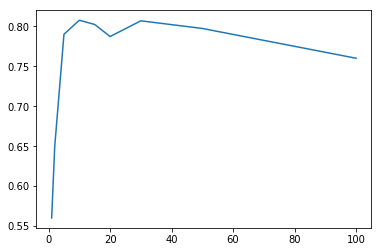

In [25]:
plt.plot(dims, mnist_accs_rf)

## Decitions Tree

In [26]:
dec_tree = DecisionTreeClassifier(random_state=0)
dec_tree.fit(mnist_train_encoded[7], mnist_labels_train_perm)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [27]:
tree_test_prediction = dec_tree.predict(mnist_test_encoded[7])
accuracy_score(y_pred=tree_test_prediction, y_true=mnist_labels_test_perm)

0.8204285714285714

## MNIST Decision tree for J=1,2,5,10,15,20,30,50,100

In [28]:
mnist_decision_tree_models = train_decision_tree_reduced_space(dims, mnist_train_encoded, mnist_labels_train_perm)

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


In [29]:
# mnist_decision_tree_models[0].predict(mnist_test_encoded[0])[:20,:]

In [30]:
mnist_accs_decision_tree = analyse_reduced_space(dims, mnist_decision_tree_models, mnist_test_encoded, mnist_labels_test_perm)





In [29]:
mnist_accs_decision_tree

[0.48814285714285716,
 0.7022857142857143,
 0.8631428571428571,
 0.8498571428571429,
 0.8447142857142858,
 0.8311428571428572,
 0.8328571428571429,
 0.8224285714285714,
 0.8237142857142857]

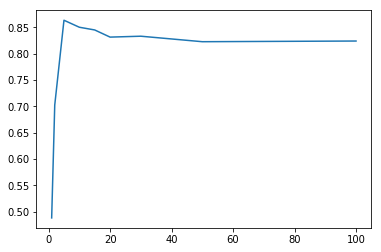

In [30]:
plt.plot(dims, mnist_accs_decision_tree)

## MNIST FF Neural Network for J=1,2,5,10,15,20,30,50,100

In [32]:


nn_mnist_accuracies = train_and_analyse_simple_nn_reduced_space(
    dims=dims, 
    train_encoded=mnist_train_encoded, 
    train_labels=mnist_labels_train_perm, 
    test_encoded=mnist_test_encoded, 
    test_labels=mnist_labels_test_perm, 
    epochs=5
)

/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Train accuracy: 30.7%
Test accuracy: 30.54%
Train accuracy: 31.19%
Test accuracy: 30.89%
Train accuracy: 31.11%
Test accuracy: 30.89%
Train accuracy: 31.16%
Test accuracy: 30.91%
Train accuracy: 31.2%
Test accuracy: 31.14%
Trained for dim 1
Accuracy 0.31142857670783997
Train accuracy: 56.88%
Test accuracy: 56.6%
Train accuracy: 56.84%
Test accuracy: 56.8%
Train accuracy: 56.92%
Test accuracy: 56.46%
Train accuracy: 56.91%
Test accuracy: 56.43%
Train accuracy: 57.4%
Test accuracy: 56.97%
Trained for dim 2
Accuracy 0.5697143077850342
Train accuracy: 83.86%
Test accuracy: 84.0%
Train accuracy: 84.09%
Test accuracy: 84.4%
Train accuracy: 84.01%
Test accuracy: 83.99%
Train accuracy: 84.4%
Test accuracy: 84.54%
Train accuracy: 84.43%
Test accuracy: 84.54%
Trained for dim 5
Accuracy 0.8454285860061646
Train accuracy: 93.66%
Test accuracy: 92.63%
Train accuracy: 93.85%
Test accuracy: 92.96%
Train accuracy: 94.51%
Test accuracy: 93.4%
Train accuracy: 94.58%
Test accuracy: 93.6%
Train accuracy: 

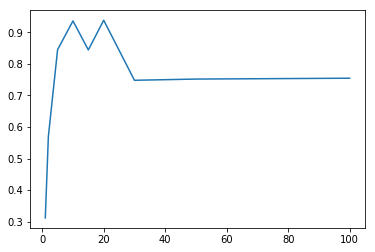

In [33]:
plt.plot(dims, nn_mnist_accuracies) 

## MNIST Naive Bayes Classifier 

In [36]:
mnist_train_labels_integers = mnist_onehot_encoder.inverse_transform(mnist_labels_train_perm).reshape(-1)
mnist_test_labels_integers = mnist_onehot_encoder.inverse_transform(mnist_labels_test_perm).reshape(-1)
mnist_train_labels_integers.shape, mnist_test_labels_integers.shape

((63000,), (7000,))

In [37]:
mnist_naive_bayes_models = train_naive_bayes_reduced_space(dims, mnist_train_encoded, mnist_train_labels_integers)

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


In [38]:
mnist_accs_naive_bayes = analyse_reduced_space(dims, mnist_naive_bayes_models, mnist_test_encoded, mnist_test_labels_integers)


In [39]:
mnist_accs_naive_bayes

[0.5172857142857142,
 0.6627142857142857,
 0.8482857142857143,
 0.8604285714285714,
 0.8625714285714285,
 0.8594285714285714,
 0.8597142857142858,
 0.8628571428571429,
 0.8478571428571429]

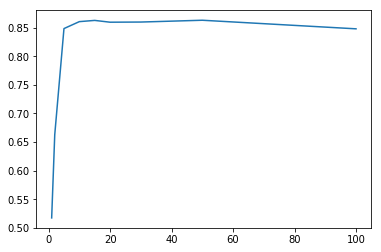

In [40]:
plt.plot(dims, mnist_accs_naive_bayes)

## Poliblog Encode data to lower dimensions J=1,2,5,10,15,20,30,50,100

In [42]:
poliblog_train_encoded, poliblog_test_encoded = reduce_dimension_vae(
    dims=dims, 
    train_data=poliblog_data_train_perm,
    test_data=poliblog_data_test,
    train_labels=poliblog_ratings_train_one_hot_perm,
    hidden_dims=[512,256,128],
    epochs=epochs
)

VAE for [512, 256, 128]
Hidden shape: (?, 1)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 1292]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 8
epoch: 0
Train accuracy 0.5916230082511902
epoch: 1
Train accuracy 0.5916230082511902
epoch: 2
Train accuracy 0.5916230082511902
epoch: 3
Train accuracy 0.5916230082511902
epoch: 4
Train accuracy 0.5916230082511902
VAE for [512, 256, 128]
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 1292]
n_batches: 8
epoch: 0
Train accuracy 0.5916230082511902
epoch: 1
Train accuracy 0.5916230082511902
epoch: 2
Train accuracy 0.5916230082511902
epoch: 3
Train accuracy 0.5916230082511902
epoch: 4
Train accuracy 0.5916230082511902
VAE for [512, 256, 128]
Hidden shape: (?, 5)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 1292]
n_batches: 8
epoch: 0
Train accuracy 0.5916230082511902
epoch: 1
Train accuracy 0.5916230082511902
epoch: 2
Train accuracy 0.5916230082511902
epoch: 3
Train accuracy 0.5916230082511902
epoch: 4
Train accuracy 0.5916230082511902
VAE for [512, 256, 128]
Hidden shape

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


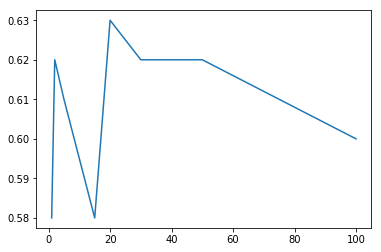

In [43]:
poliblog_train_labels_integers = poliblog_onehot_encoder.inverse_transform(poliblog_ratings_train_one_hot_perm).reshape(-1)
poliblog_test_labels_integers = poliblog_onehot_encoder.inverse_transform(poliblog_ratings_test_one_hot).reshape(-1)


poliblog_rf_models = train_rf_reduced_space(dims, poliblog_train_encoded, poliblog_train_labels_integers)
poliblog_accs_rf = analyse_reduced_space(dims, poliblog_rf_models, poliblog_test_encoded, poliblog_test_labels_integers)
plt.plot(dims, poliblog_accs_rf)

In [44]:
poliblog_accs_rf

[0.58, 0.62, 0.61, 0.595, 0.58, 0.63, 0.62, 0.62, 0.6]

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


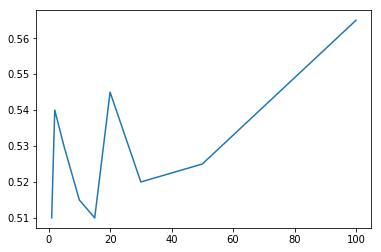

In [45]:
poliblog_decision_tree_models = train_decision_tree_reduced_space(dims, poliblog_train_encoded, poliblog_ratings_train_one_hot_perm)
poliblog_accs_decision_tree = analyse_reduced_space(dims, poliblog_decision_tree_models, poliblog_test_encoded, poliblog_ratings_test_one_hot)
plt.plot(dims, poliblog_accs_decision_tree)


In [46]:
poliblog_accs_decision_tree

[0.51, 0.54, 0.53, 0.515, 0.51, 0.545, 0.52, 0.525, 0.565]

In [47]:
poliblog_ratings_train_one_hot_perm.shape[1]

2

In [48]:
nn_poliblog_accuracies = train_and_analyse_simple_nn_reduced_space(
    dims=dims, 
    train_encoded=poliblog_train_encoded, 
    train_labels=poliblog_ratings_train_one_hot_perm, 
    test_encoded=poliblog_test_encoded, 
    test_labels=poliblog_ratings_test_one_hot, 
    epochs=5
)

/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Train accuracy: 59.16%
Test accuracy: 62.5%
Train accuracy: 59.16%
Test accuracy: 62.5%
Train accuracy: 59.16%
Test accuracy: 62.5%
Train accuracy: 59.16%
Test accuracy: 62.5%
Train accuracy: 59.16%
Test accuracy: 62.5%
Trained for dim 1
Accuracy 0.625
Train accuracy: 59.16%
Test accuracy: 62.5%
Train accuracy: 59.16%
Test accuracy: 62.5%
Train accuracy: 59.16%
Test accuracy: 62.5%
Train accuracy: 59.16%
Test accuracy: 62.5%
Train accuracy: 59.16%
Test accuracy: 62.5%
Trained for dim 2
Accuracy 0.625
Train accuracy: 59.34%
Test accuracy: 62.5%
Train accuracy: 59.16%
Test accuracy: 62.5%
Train accuracy: 59.16%
Test accuracy: 62.5%
Train accuracy: 59.16%
Test accuracy: 62.5%
Train accuracy: 59.16%
Test accuracy: 62.5%
Trained for dim 5
Accuracy 0.625
Train accuracy: 59.86%
Test accuracy: 61.5%
Train accuracy: 61.78%
Test accuracy: 56.5%
Train accuracy: 62.3%
Test accuracy: 60.5%
Train accuracy: 62.13%
Test accuracy: 62.0%
Train accuracy: 63.87%
Test accuracy: 57.0%
Trained for dim 10
Acc

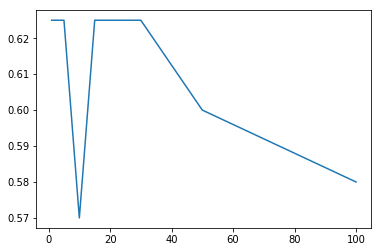

In [49]:
plt.plot(dims, nn_poliblog_accuracies)


## Poliblog naive bayes

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


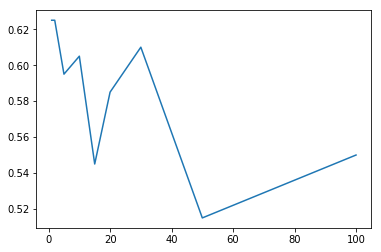

In [50]:
poliblog_train_labels_integers = poliblog_onehot_encoder.inverse_transform(poliblog_ratings_train_one_hot_perm).reshape(-1)
poliblog_test_labels_integers = poliblog_onehot_encoder.inverse_transform(poliblog_ratings_test_one_hot).reshape(-1)
poliblog_train_labels_integers.shape,poliblog_test_labels_integers.shape

poliblog_naive_bayes_models = train_naive_bayes_reduced_space(dims, poliblog_train_encoded, poliblog_train_labels_integers)
poliblog_accs_naive_bayes = analyse_reduced_space(dims, poliblog_naive_bayes_models, poliblog_test_encoded, poliblog_test_labels_integers)
plt.plot(dims, poliblog_accs_naive_bayes)


In [51]:
poliblog_accs_naive_bayes

[0.625, 0.625, 0.595, 0.605, 0.545, 0.585, 0.61, 0.515, 0.55]

## SmsSpam data reduced to J=1,2,5,10,15,20,30,50,100

In [52]:
smsspam_train_encoded, smsspam_test_encoded = reduce_dimension_vae(
    dims=dims, 
    train_data=smsSpam_data_train_perm,
    test_data=smsSpam_data_test,
    train_labels=smsSpam_labels_train_one_hot_perm,
    hidden_dims=[512,256,128],
    epochs=epochs
)

VAE for [512, 256, 128]
Hidden shape: (?, 1)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 18]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 11
epoch: 0
Train accuracy 0.27628031373023987
epoch: 1
Train accuracy 0.27628031373023987
epoch: 2
Train accuracy 0.27628031373023987
epoch: 3
Train accuracy 0.27628031373023987
epoch: 4
Train accuracy 0.27628031373023987
VAE for [512, 256, 128]
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 18]
n_batches: 11
epoch: 0
Train accuracy 0.27628031373023987
epoch: 1
Train accuracy 0.27628031373023987
epoch: 2
Train accuracy 0.27628031373023987
epoch: 3
Train accuracy 0.27628031373023987
epoch: 4
Train accuracy 0.27628031373023987
VAE for [512, 256, 128]
Hidden shape: (?, 5)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 18]
n_batches: 11
epoch: 0
Train accuracy 0.7183288335800171
epoch: 1
Train accuracy 0.7223719954490662
epoch: 2
Train accuracy 0.7183288335800171
epoch: 3
Train accuracy 0.7035040259361267
epoch: 4
Train accuracy 0.7210242748260498
VAE for [512, 256, 128]
Hid

## SmsSpam Random Forest

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


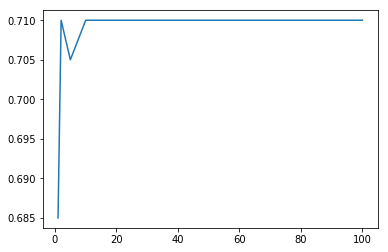

In [53]:
smsspam_rf_models = train_rf_reduced_space(dims, smsspam_train_encoded, smsSpam_labels_train_one_hot_perm)
smsspam_accs_rf = analyse_reduced_space(dims, smsspam_rf_models, smsspam_test_encoded, smsSpam_labels_test_one_hot)
plt.plot(dims, smsspam_accs_rf)

In [54]:
np.max(smsspam_accs_rf)

0.71

## SmsSpam Decision Tree

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


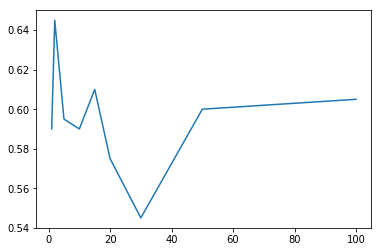

In [55]:
smsspam_decision_tree_models = train_decision_tree_reduced_space(dims, smsspam_train_encoded, smsSpam_labels_train_one_hot_perm)
smsspam_accs_decision_tree = analyse_reduced_space(dims, smsspam_decision_tree_models, smsspam_test_encoded, smsSpam_labels_test_one_hot)
plt.plot(dims, smsspam_accs_decision_tree)


In [56]:
np.max(smsspam_accs_decision_tree)

0.645

## FF NN

In [57]:
nn_smsspam_accuracies = train_and_analyse_simple_nn_reduced_space(
    dims=dims, 
    train_encoded=smsspam_train_encoded, 
    train_labels=smsSpam_labels_train_one_hot_perm, 
    test_encoded=smsspam_test_encoded, 
    test_labels=smsSpam_labels_test_one_hot, 
    epochs=5
)

/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Train accuracy: 27.63%
Test accuracy: 29.0%
Train accuracy: 27.63%
Test accuracy: 29.0%
Train accuracy: 27.63%
Test accuracy: 29.0%
Train accuracy: 27.63%
Test accuracy: 29.0%
Train accuracy: 27.63%
Test accuracy: 29.0%
Trained for dim 1
Accuracy 0.28999999165534973
Train accuracy: 72.37%
Test accuracy: 71.0%
Train accuracy: 72.37%
Test accuracy: 71.0%
Train accuracy: 72.37%
Test accuracy: 71.0%
Train accuracy: 72.37%
Test accuracy: 71.0%
Train accuracy: 72.37%
Test accuracy: 71.0%
Trained for dim 2
Accuracy 0.7099999785423279
Train accuracy: 72.37%
Test accuracy: 71.0%
Train accuracy: 72.37%
Test accuracy: 71.0%
Train accuracy: 72.37%
Test accuracy: 71.0%
Train accuracy: 72.37%
Test accuracy: 71.0%
Train accuracy: 72.37%
Test accuracy: 71.0%
Trained for dim 5
Accuracy 0.7099999785423279
Train accuracy: 72.37%
Test accuracy: 71.0%
Train accuracy: 72.37%
Test accuracy: 71.0%
Train accuracy: 72.37%
Test accuracy: 71.0%
Train accuracy: 72.37%
Test accuracy: 71.0%
Train accuracy: 72.37%
Te

## Naive Bayes

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


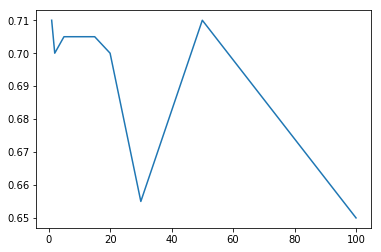

In [58]:
smsspam_train_labels_integers = smsSpam_onehot_encoder.inverse_transform(smsSpam_labels_train_one_hot_perm).reshape(-1)
smsspam_test_labels_integers = smsSpam_onehot_encoder.inverse_transform(smsSpam_labels_test_one_hot).reshape(-1)

smsspam_naive_bayes_models = train_naive_bayes_reduced_space(dims, smsspam_train_encoded, smsspam_train_labels_integers)
smsspam_accs_naive_bayes = analyse_reduced_space(dims, smsspam_naive_bayes_models, smsspam_test_encoded, smsspam_test_labels_integers)
plt.plot(dims, smsspam_accs_naive_bayes)


In [59]:
np.max(smsspam_accs_naive_bayes)

0.71

## Reuters2 reduce dim

In [60]:
reuters2_train_encoded, reuters2_test_encoded = reduce_dimension_vae(
    dims=dims, 
    train_data=reuters2_data_train_perm,
    test_data=reuters2_data_test,
    train_labels=reuters2_labels_train_one_hot_perm,
    hidden_dims=[512,256,128],
    epochs=epochs
)

VAE for [512, 256, 128]
Hidden shape: (?, 1)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 2002]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 16
epoch: 0
Train accuracy 0.4755639135837555
epoch: 1
Train accuracy 0.4501879811286926
epoch: 2
Train accuracy 0.548872172832489
epoch: 3
Train accuracy 0.548872172832489
epoch: 4
Train accuracy 0.548872172832489
VAE for [512, 256, 128]
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 2002]
n_batches: 16
epoch: 0
Train accuracy 0.4887218177318573
epoch: 1
Train accuracy 0.548872172832489
epoch: 2
Train accuracy 0.548872172832489
epoch: 3
Train accuracy 0.548872172832489
epoch: 4
Train accuracy 0.548872172832489
VAE for [512, 256, 128]
Hidden shape: (?, 5)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 2002]
n_batches: 16
epoch: 0
Train accuracy 0.548872172832489
epoch: 1
Train accuracy 0.548872172832489
epoch: 2
Train accuracy 0.548872172832489
epoch: 3
Train accuracy 0.548872172832489
epoch: 4
Train accuracy 0.548872172832489
VAE for [512, 256, 128]
Hidden shape: (?, 10)

## reuters2 Random Forest

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


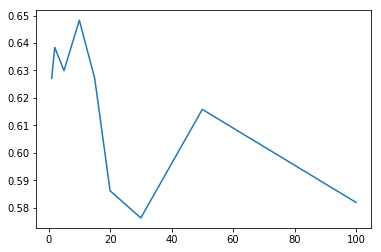

In [61]:
reuters2_train_labels_integers = reuters2_onehot_encoder.inverse_transform(reuters2_labels_train_one_hot_perm).reshape(-1)
reuters2_test_labels_integers = reuters2_onehot_encoder.inverse_transform(reuters2_labels_test_one_hot).reshape(-1)

reuters2_rf_models = train_rf_reduced_space(dims, reuters2_train_encoded, reuters2_train_labels_integers)
reuters2_accs_rf = analyse_reduced_space(dims, reuters2_rf_models, reuters2_test_encoded, reuters2_test_labels_integers)
plt.plot(dims, reuters2_accs_rf)

In [62]:
np.max(reuters2_accs_rf)

0.6483050847457628

## reuters2 decision tree

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


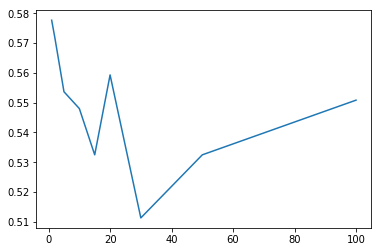

In [63]:
reuters2_decision_tree_models = train_decision_tree_reduced_space(dims, reuters2_train_encoded, reuters2_labels_train_one_hot_perm)
reuters2_accs_decision_tree = analyse_reduced_space(dims, reuters2_decision_tree_models, reuters2_test_encoded, reuters2_labels_test_one_hot)
plt.plot(dims, reuters2_accs_decision_tree)


In [64]:
np.max(reuters2_accs_decision_tree)

0.577683615819209

## FF NN

In [65]:
nn_reuters2_accuracies = train_and_analyse_simple_nn_reduced_space(
    dims=dims, 
    train_encoded=reuters2_train_encoded, 
    train_labels=reuters2_labels_train_one_hot_perm, 
    test_encoded=reuters2_test_encoded, 
    test_labels=reuters2_labels_test_one_hot, 
    epochs=5
)

/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Train accuracy: 54.89%
Test accuracy: 54.52%
Train accuracy: 55.08%
Test accuracy: 54.94%
Train accuracy: 55.64%
Test accuracy: 55.79%
Train accuracy: 56.48%
Test accuracy: 55.51%
Train accuracy: 57.8%
Test accuracy: 56.92%
Trained for dim 1
Accuracy 0.5692090392112732
Train accuracy: 57.14%
Test accuracy: 57.77%
Train accuracy: 58.46%
Test accuracy: 59.46%
Train accuracy: 57.99%
Test accuracy: 58.47%
Train accuracy: 56.95%
Test accuracy: 58.05%
Train accuracy: 58.27%
Test accuracy: 59.6%
Trained for dim 2
Accuracy 0.596045196056366
Train accuracy: 60.06%
Test accuracy: 56.78%
Train accuracy: 60.15%
Test accuracy: 57.91%
Train accuracy: 61.18%
Test accuracy: 58.9%
Train accuracy: 61.84%
Test accuracy: 60.31%
Train accuracy: 62.59%
Test accuracy: 59.32%
Trained for dim 5
Accuracy 0.5932203531265259
Train accuracy: 60.43%
Test accuracy: 59.18%
Train accuracy: 61.75%
Test accuracy: 59.04%
Train accuracy: 65.04%
Test accuracy: 61.44%
Train accuracy: 65.7%
Test accuracy: 62.15%
Train accura

## reuters2 Naive Bayes

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


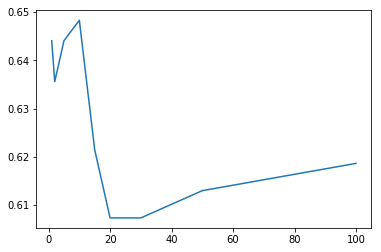

In [66]:
reuters2_train_labels_integers = reuters2_onehot_encoder.inverse_transform(reuters2_labels_train_one_hot_perm).reshape(-1)
reuters2_test_labels_integers = reuters2_onehot_encoder.inverse_transform(reuters2_labels_test_one_hot).reshape(-1)

reuters2_naive_bayes_models = train_naive_bayes_reduced_space(dims, reuters2_train_encoded, reuters2_train_labels_integers)
reuters2_accs_naive_bayes = analyse_reduced_space(dims, reuters2_naive_bayes_models, reuters2_test_encoded, reuters2_test_labels_integers)
plt.plot(dims, reuters2_accs_naive_bayes)


In [67]:
np.max(reuters2_accs_naive_bayes)

0.6483050847457628

## reuters3 reduce dim

In [68]:
reuters3_train_encoded, reuters3_test_encoded = reduce_dimension_vae(
    dims=dims, 
    train_data=reuters3_data_train_perm,
    test_data=reuters3_data_test,
    train_labels=reuters3_labels_train_one_hot_perm,
    hidden_dims=[512,256,128],
    epochs=epochs
)

VAE for [512, 256, 128]
Hidden shape: (?, 1)
self.posterior_predictive_probs_y.shape [None, 3]
self.y.shape [None, 3]
xy.shape [None, 2003]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 25
epoch: 0
Train accuracy 0.357099711894989
epoch: 1
Train accuracy 0.35770392417907715
epoch: 2
Train accuracy 0.3589123785495758
epoch: 3
Train accuracy 0.2670694887638092
epoch: 4
Train accuracy 0.3564954698085785
VAE for [512, 256, 128]
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 3]
self.y.shape [None, 3]
xy.shape [None, 2003]
n_batches: 25
epoch: 0
Train accuracy 0.357099711894989
epoch: 1
Train accuracy 0.357099711894989
epoch: 2
Train accuracy 0.357099711894989
epoch: 3
Train accuracy 0.357099711894989
epoch: 4
Train accuracy 0.357099711894989
VAE for [512, 256, 128]
Hidden shape: (?, 5)
self.posterior_predictive_probs_y.shape [None, 3]
self.y.shape [None, 3]
xy.shape [None, 2003]
n_batches: 25
epoch: 0
Train accuracy 0.334138959646225
epoch: 1
Train accuracy 0.2972809672355652
epoch: 2
Train accuracy 0.28761330246925354
epoch: 3
Train accuracy 0.287009060382843
epoch: 4
Train accuracy 0.287009060382843
VAE for [512, 256, 128]
Hidden shape: (?

## reuters3 Random Forest

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


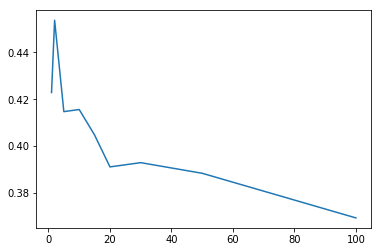

In [69]:
reuters3_train_labels_integers = reuters3_onehot_encoder.inverse_transform(reuters3_labels_train_one_hot_perm).reshape(-1)
reuters3_test_labels_integers = reuters3_onehot_encoder.inverse_transform(reuters3_labels_test_one_hot).reshape(-1)


reuters3_rf_models = train_rf_reduced_space(dims, reuters3_train_encoded, reuters3_train_labels_integers)
reuters3_accs_rf = analyse_reduced_space(dims, reuters3_rf_models, reuters3_test_encoded, reuters3_test_labels_integers)
plt.plot(dims, reuters3_accs_rf)

In [70]:
np.max(reuters3_accs_rf)

0.4537205081669691

## reuters3 decision tree

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


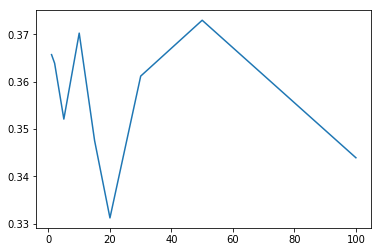

In [71]:
reuters3_train_labels_integers = reuters3_onehot_encoder.inverse_transform(reuters3_labels_train_one_hot_perm).reshape(-1)
reuters3_test_labels_integers = reuters3_onehot_encoder.inverse_transform(reuters3_labels_test_one_hot).reshape(-1)

reuters3_decision_tree_models = train_decision_tree_reduced_space(dims, reuters3_train_encoded, reuters3_train_labels_integers)
reuters3_accs_decision_tree = analyse_reduced_space(dims, reuters3_decision_tree_models, reuters3_test_encoded, reuters3_test_labels_integers)
plt.plot(dims, reuters3_accs_decision_tree)


In [72]:
np.max(reuters3_accs_decision_tree)

0.37295825771324864

## FF NN

In [73]:
nn_reuters3_accuracies = train_and_analyse_simple_nn_reduced_space(
    dims=dims, 
    train_encoded=reuters3_train_encoded, 
    train_labels=reuters3_labels_train_one_hot_perm, 
    test_encoded=reuters3_test_encoded, 
    test_labels=reuters3_labels_test_one_hot, 
    epochs=5
)

/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Train accuracy: 29.0%
Test accuracy: 28.95%
Train accuracy: 29.0%
Test accuracy: 28.95%
Train accuracy: 29.0%
Test accuracy: 28.95%
Train accuracy: 29.0%
Test accuracy: 28.95%
Train accuracy: 29.0%
Test accuracy: 28.95%
Trained for dim 1
Accuracy 0.28947368264198303
Train accuracy: 29.0%
Test accuracy: 28.95%
Train accuracy: 29.0%
Test accuracy: 28.95%
Train accuracy: 29.0%
Test accuracy: 28.95%
Train accuracy: 29.0%
Test accuracy: 28.95%
Train accuracy: 29.0%
Test accuracy: 28.95%
Trained for dim 2
Accuracy 0.28947368264198303
Train accuracy: 39.88%
Test accuracy: 39.2%
Train accuracy: 41.69%
Test accuracy: 41.65%
Train accuracy: 43.08%
Test accuracy: 42.01%
Train accuracy: 41.69%
Test accuracy: 42.29%
Train accuracy: 43.38%
Test accuracy: 43.47%
Trained for dim 5
Accuracy 0.434664249420166
Train accuracy: 34.98%
Test accuracy: 31.94%
Train accuracy: 39.27%
Test accuracy: 38.57%
Train accuracy: 42.42%
Test accuracy: 37.3%
Train accuracy: 44.53%
Test accuracy: 39.66%
Train accuracy: 47

## Naive Bayes

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


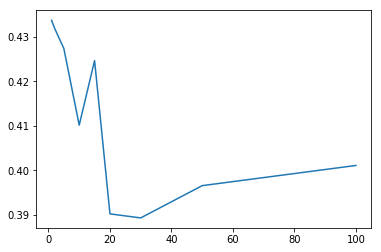

In [74]:
reuters3_train_labels_integers = reuters3_onehot_encoder.inverse_transform(reuters3_labels_train_one_hot_perm).reshape(-1)
reuters3_test_labels_integers = reuters3_onehot_encoder.inverse_transform(reuters3_labels_test_one_hot).reshape(-1)

reuters3_naive_bayes_models = train_naive_bayes_reduced_space(dims, reuters3_train_encoded, reuters3_train_labels_integers)
reuters3_accs_naive_bayes = analyse_reduced_space(dims, reuters3_naive_bayes_models, reuters3_test_encoded, reuters3_test_labels_integers)
plt.plot(dims, reuters3_accs_naive_bayes)


In [75]:
np.max(reuters3_accs_naive_bayes)

0.4337568058076225

## reuters5 reduce dim

In [76]:
reuters5_train_encoded, reuters5_test_encoded = reduce_dimension_vae(
    dims=dims, 
    train_data=reuters5_data_train_perm,
    test_data=reuters5_data_test,
    train_labels=reuters5_labels_train_one_hot_perm,
    hidden_dims=[512,256,128],
    epochs=epochs
)

VAE for [512, 256, 128]
Hidden shape: (?, 1)
self.posterior_predictive_probs_y.shape [None, 5]
self.y.shape [None, 5]
xy.shape [None, 2005]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 44
epoch: 0
Train accuracy 0.17003187537193298
epoch: 1
Train accuracy 0.17003187537193298
epoch: 2
Train accuracy 0.17003187537193298
epoch: 3
Train accuracy 0.17003187537193298
epoch: 4
Train accuracy 0.1686149537563324
VAE for [512, 256, 128]
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 5]
self.y.shape [None, 5]
xy.shape [None, 2005]
n_batches: 44
epoch: 0
Train accuracy 0.2068721204996109
epoch: 1
Train accuracy 0.2068721204996109
epoch: 2
Train accuracy 0.2068721204996109
epoch: 3
Train accuracy 0.2068721204996109
epoch: 4
Train accuracy 0.2068721204996109
VAE for [512, 256, 128]
Hidden shape: (?, 5)
self.posterior_predictive_probs_y.shape [None, 5]
self.y.shape [None, 5]
xy.shape [None, 2005]
n_batches: 44
epoch: 0
Train accuracy 0.2075805813074112
epoch: 1
Train accuracy 0.20864328742027283
epoch: 2
Train accuracy 0.20439249277114868
epoch: 3
Train accuracy 0.20439249277114868
epoch: 4
Train accuracy 0.20722635090351105
VAE for [512, 256, 128]
H

## reuters5 random forest

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


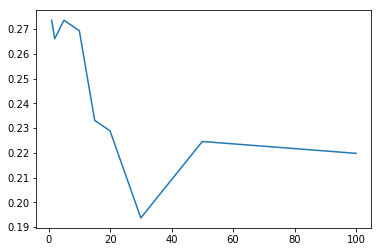

In [77]:
reuters5_train_labels_integers = reuters5_onehot_encoder.inverse_transform(reuters5_labels_train_one_hot_perm).reshape(-1)
reuters5_test_labels_integers = reuters5_onehot_encoder.inverse_transform(reuters5_labels_test_one_hot).reshape(-1)


reuters5_rf_models = train_rf_reduced_space(dims, reuters5_train_encoded, reuters5_train_labels_integers)
reuters5_accs_rf = analyse_reduced_space(dims, reuters5_rf_models, reuters5_test_encoded, reuters5_test_labels_integers)
plt.plot(dims, reuters5_accs_rf)

In [78]:
np.max(reuters5_accs_rf)

0.27354976051091007

## reuters5 decision tree

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


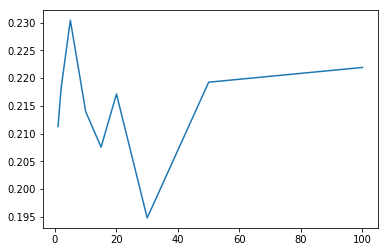

In [79]:
reuters5_train_labels_integers = reuters5_onehot_encoder.inverse_transform(reuters5_labels_train_one_hot_perm).reshape(-1)
reuters5_test_labels_integers = reuters5_onehot_encoder.inverse_transform(reuters5_labels_test_one_hot).reshape(-1)

reuters5_decision_tree_models = train_decision_tree_reduced_space(dims, reuters5_train_encoded, reuters5_train_labels_integers)
reuters5_accs_decision_tree = analyse_reduced_space(dims, reuters5_decision_tree_models, reuters5_test_encoded, reuters5_test_labels_integers)
plt.plot(dims, reuters5_accs_decision_tree)


In [80]:
np.max(reuters5_accs_decision_tree)

0.23044172432144758

## FF NN

In [81]:
nn_reuters5_accuracies = train_and_analyse_simple_nn_reduced_space(
    dims=dims, 
    train_encoded=reuters5_train_encoded, 
    train_labels=reuters5_labels_train_one_hot_perm, 
    test_encoded=reuters5_test_encoded, 
    test_labels=reuters5_labels_test_one_hot, 
    epochs=5
)

/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Train accuracy: 17.0%
Test accuracy: 16.98%
Train accuracy: 17.0%
Test accuracy: 16.98%
Train accuracy: 17.0%
Test accuracy: 16.98%
Train accuracy: 17.0%
Test accuracy: 16.98%
Train accuracy: 17.0%
Test accuracy: 16.98%
Trained for dim 1
Accuracy 0.16977114975452423
Train accuracy: 22.67%
Test accuracy: 20.12%
Train accuracy: 22.74%
Test accuracy: 23.47%
Train accuracy: 23.63%
Test accuracy: 23.04%
Train accuracy: 25.82%
Test accuracy: 25.55%
Train accuracy: 25.89%
Test accuracy: 26.18%
Trained for dim 2
Accuracy 0.26184141635894775
Train accuracy: 20.58%
Test accuracy: 19.37%
Train accuracy: 23.17%
Test accuracy: 22.25%
Train accuracy: 21.82%
Test accuracy: 20.54%
Train accuracy: 24.87%
Test accuracy: 22.57%
Train accuracy: 24.65%
Test accuracy: 21.98%
Trained for dim 5
Accuracy 0.2197977602481842
Train accuracy: 19.34%
Test accuracy: 18.63%
Train accuracy: 20.16%
Test accuracy: 19.74%
Train accuracy: 22.71%
Test accuracy: 22.14%
Train accuracy: 23.13%
Test accuracy: 22.67%
Train accu

## Naive Bayes

Trained for dim 1
Trained for dim 2
Trained for dim 5
Trained for dim 10
Trained for dim 15
Trained for dim 20
Trained for dim 30
Trained for dim 50
Trained for dim 100


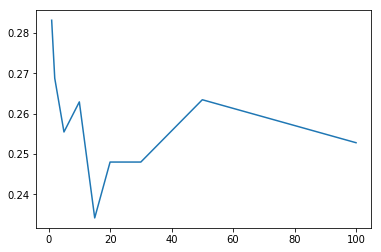

In [82]:
reuters5_train_labels_integers = reuters5_onehot_encoder.inverse_transform(reuters5_labels_train_one_hot_perm).reshape(-1)
reuters5_test_labels_integers = reuters5_onehot_encoder.inverse_transform(reuters5_labels_test_one_hot).reshape(-1)

reuters5_naive_bayes_models = train_naive_bayes_reduced_space(dims, reuters5_train_encoded, reuters5_train_labels_integers)
reuters5_accs_naive_bayes = analyse_reduced_space(dims, reuters5_naive_bayes_models, reuters5_test_encoded, reuters5_test_labels_integers)
plt.plot(dims, reuters5_accs_naive_bayes)


In [83]:
np.max(reuters5_accs_naive_bayes)

0.2831293241085684

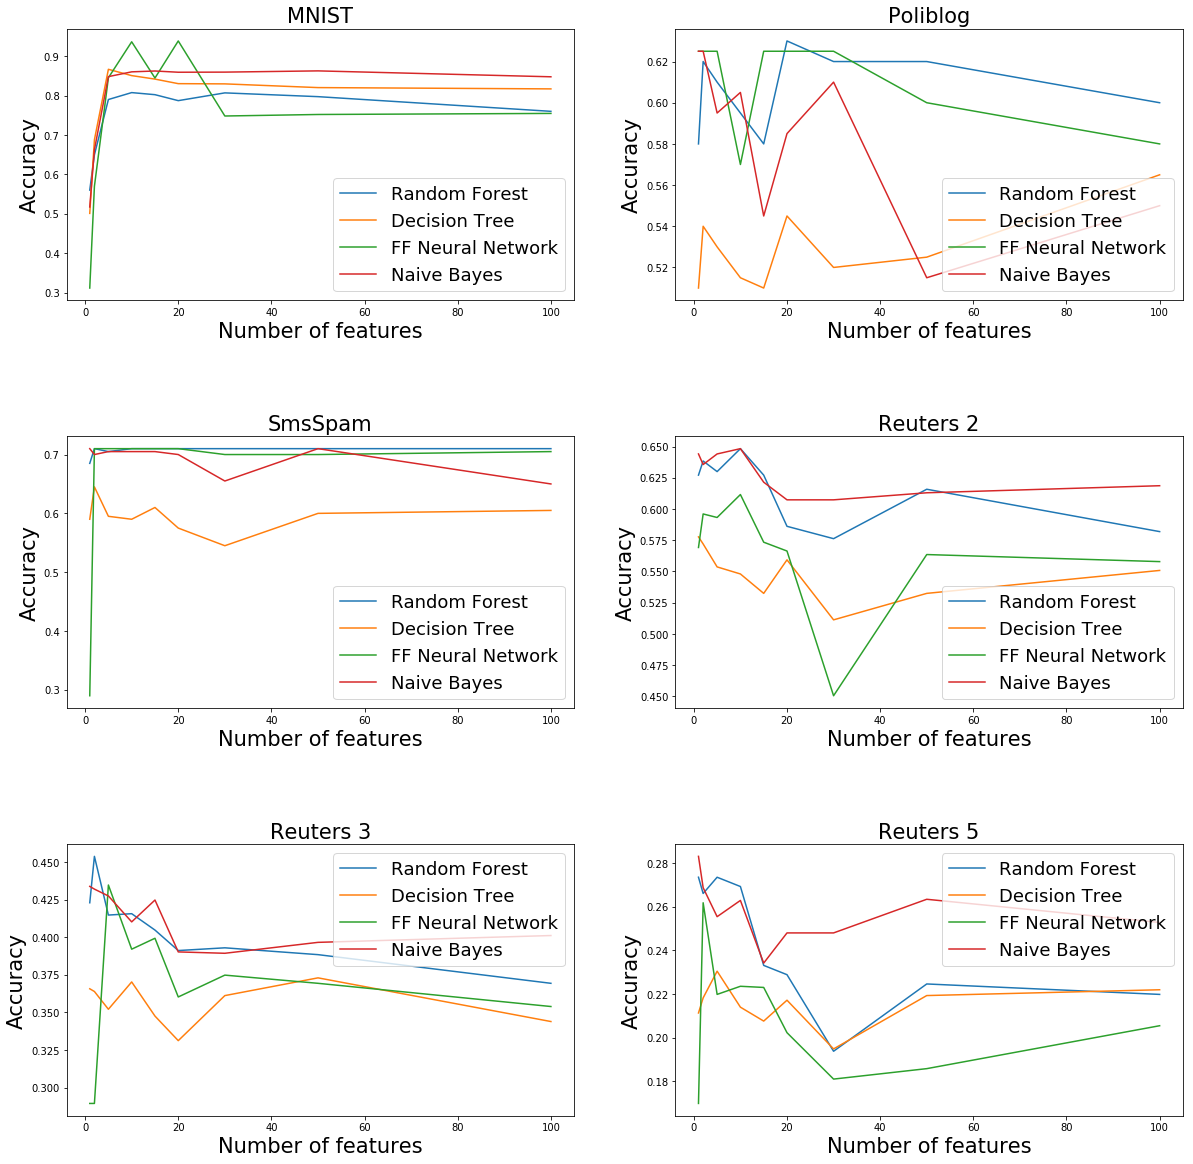

In [95]:
fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)

xlabel="Number of features"

plt.subplot(3, 2, 1)
plt.plot(dims, mnist_accs_rf, label='Random Forest')
plt.plot(dims, mnist_accs_decision_tree, label='Decision Tree')
plt.plot(dims, nn_mnist_accuracies, label='FF Neural Network') 
plt.plot(dims, mnist_accs_naive_bayes, label='Naive Bayes') 

plt.title("MNIST", fontsize=21)
plt.xlabel(xlabel, fontsize=21)
plt.ylabel("Accuracy", fontsize=21)
plt.legend(loc='best', fontsize=18)

plt.subplot(3, 2, 2)
plt.plot(dims, poliblog_accs_rf, label='Random Forest')
plt.plot(dims, poliblog_accs_decision_tree, label='Decision Tree')
plt.plot(dims, nn_poliblog_accuracies, label='FF Neural Network') 
plt.plot(dims, poliblog_accs_naive_bayes, label='Naive Bayes') 

plt.title("Poliblog", fontsize=21)
plt.xlabel(xlabel, fontsize=21)
plt.ylabel("Accuracy", fontsize=21)
plt.legend(loc='best', fontsize=18)

plt.subplot(3, 2, 3)
plt.plot(dims, smsspam_accs_rf, label='Random Forest')
plt.plot(dims, smsspam_accs_decision_tree, label='Decision Tree')
plt.plot(dims, nn_smsspam_accuracies, label='FF Neural Network') 
plt.plot(dims, smsspam_accs_naive_bayes, label='Naive Bayes') 

plt.title("SmsSpam", fontsize=21)
plt.xlabel(xlabel, fontsize=21)
plt.ylabel("Accuracy", fontsize=21)
plt.legend(loc='best', fontsize=18)

plt.subplot(3, 2, 4)
plt.plot(dims, reuters2_accs_rf, label='Random Forest')
plt.plot(dims, reuters2_accs_decision_tree, label='Decision Tree')
plt.plot(dims, nn_reuters2_accuracies, label='FF Neural Network') 
plt.plot(dims, reuters2_accs_naive_bayes, label='Naive Bayes') 

plt.title("Reuters 2", fontsize=21)
plt.xlabel(xlabel, fontsize=21)
plt.ylabel("Accuracy", fontsize=21)
plt.legend(loc='best', fontsize=18)

plt.subplot(3, 2, 5)
plt.plot(dims, reuters3_accs_rf, label='Random Forest')
plt.plot(dims, reuters3_accs_decision_tree, label='Decision Tree')
plt.plot(dims, nn_reuters3_accuracies, label='FF Neural Network') 
plt.plot(dims, reuters3_accs_naive_bayes, label='Naive Bayes') 

plt.title("Reuters 3", fontsize=21)
plt.xlabel(xlabel, fontsize=21)
plt.ylabel("Accuracy", fontsize=21)
plt.legend(loc='best', fontsize=18)

plt.subplot(3, 2, 6)
plt.plot(dims, reuters5_accs_rf, label='Random Forest')
plt.plot(dims, reuters5_accs_decision_tree, label='Decision Tree')
plt.plot(dims, nn_reuters5_accuracies, label='FF Neural Network') 
plt.plot(dims, reuters5_accs_naive_bayes, label='Naive Bayes') 

plt.title("Reuters 5", fontsize=21)
plt.xlabel(xlabel, fontsize=21)
plt.ylabel("Accuracy", fontsize=21)
plt.legend(loc='best', fontsize=18)

plt.savefig('/Users/mjankowski/Desktop/vae_experiments.png', bbox_inches='tight')
plt.show()

In [65]:
nn_mnist_accuracies

[0.32342857,
 0.40071428,
 0.664,
 0.7482857,
 0.85385716,
 0.7591429,
 0.9317143,
 0.928,
 0.7664286]

In [66]:
poliblog_accs_rf

[0.625, 0.6, 0.615, 0.6, 0.635, 0.63, 0.595, 0.585, 0.605]

In [67]:
smsspam_accs_rf

[0.705, 0.71, 0.72, 0.71, 0.71, 0.71, 0.705, 0.71, 0.71]

In [68]:
reuters2_accs_rf

[0.6271186440677966,
 0.6624293785310734,
 0.6073446327683616,
 0.5805084745762712,
 0.6087570621468926,
 0.6115819209039548,
 0.6045197740112994,
 0.5932203389830508,
 0.5649717514124294]

In [69]:
reuters3_accs_rf

[0.4382940108892922,
 0.4455535390199637,
 0.43284936479128855,
 0.41742286751361163,
 0.4029038112522686,
 0.39473684210526316,
 0.42014519056261346,
 0.40381125226860254,
 0.3911070780399274]

In [70]:
reuters5_accs_rf

[0.23789249600851517,
 0.2655667908461948,
 0.24108568387440127,
 0.26450239489089944,
 0.22778073443320915,
 0.23097392229909527,
 0.2293773283661522,
 0.21128259712613093,
 0.2197977647684939]

In [76]:
def get_latent_space(train_data, train_labels, test_data, test_labels, encoder):
    log_folder = log.get_log_folder()
    print("Saving logs to {}".format(log_folder))
    model_unsupervised = StandardVaeSvae(
        x_dim=train_data.shape[1],
        y_dim=train_labels.shape[1],
        hidden_dims=[512,256,128,2],
        log_folder=log_folder,
        alpha=1,
        beta=1,
        gamma=0
    )

    model_unsupervised.fit(
        train_data, 
        train_labels, 
        epochs=5)

    train_encoded = model_unsupervised.to_latent_space(train_data)
    test_encoded = model_unsupervised.to_latent_space(test_data)
    test_decoded_labels = encoder.inverse_transform(test_labels).reshape(-1)
    train_decoded_labels = encoder.inverse_transform(train_labels).reshape(-1)
    return test_encoded, test_decoded_labels, train_encoded, train_decoded_labels

Saving logs to /tmp/class_vae/deep/04_05_2019/20190504170912
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 1292]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 8
epoch: 0
Train accuracy 0.43106457591056824
epoch: 1
Train accuracy 0.46945899724960327
epoch: 2
Train accuracy 0.4083769619464874
epoch: 3
Train accuracy 0.4083769619464874
epoch: 4
Train accuracy 0.4083769619464874


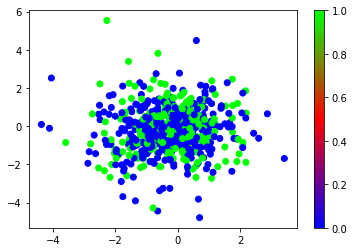

In [77]:
poliblog_test_latent_space, poliblog_test_decoded_labels, poliblog_train_latent_space, poliblog_train_decoded_labels = get_latent_space(
    train_data=poliblog_data_train_perm, 
    train_labels=poliblog_ratings_train_one_hot_perm, 
    test_data=poliblog_data_test, 
    test_labels=poliblog_ratings_test_one_hot, 
    encoder=poliblog_onehot_encoder
)
plt.scatter(poliblog_train_latent_space[:,0],poliblog_train_latent_space[:,1], c=poliblog_train_decoded_labels, cmap='brg')
plt.colorbar()


Saving logs to /tmp/class_vae/deep/04_05_2019/20190504171101
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Train accuracy 0.017523810267448425
epoch: 1
Train accuracy 0.02574603259563446
epoch: 2
Train accuracy 0.042222220450639725
epoch: 3
Train accuracy 0.03517460450530052
epoch: 4
Train accuracy 0.04280952364206314


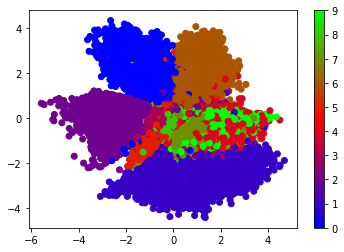

In [79]:
mnist_test_latent_space, mnist_test_decoded_labels,mnist_train_latent_space, mnist_train_decoded_labels = get_latent_space(
    train_data=mnist_train_perm, 
    train_labels=mnist_labels_train_perm, 
    test_data=mnist_test, 
    test_labels=mnist_labels_test_perm, 
    encoder=mnist_onehot_encoder
)
plt.scatter(mnist_train_latent_space[:,0],mnist_train_latent_space[:,1], c=mnist_train_decoded_labels, cmap='brg')
plt.colorbar()

Saving logs to /tmp/class_vae/deep/04_05_2019/20190504171448
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 18]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 11
epoch: 0
Train accuracy 0.7237196564674377
epoch: 1
Train accuracy 0.7237196564674377
epoch: 2
Train accuracy 0.7237196564674377
epoch: 3
Train accuracy 0.7237196564674377
epoch: 4
Train accuracy 0.7237196564674377


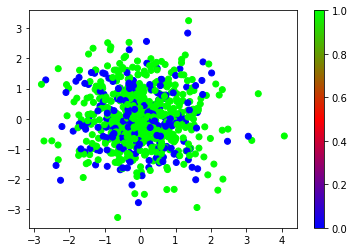

In [81]:
smsSpam_test_latent_space, smsSpam_test_decoded_labels, smsSpam_train_latent_space, smsSpam_train_decoded_labels = get_latent_space(
    train_data=smsSpam_data_train_perm, 
    train_labels=smsSpam_labels_train_one_hot_perm, 
    test_data=smsSpam_data_test, 
    test_labels=smsSpam_labels_test_one_hot, 
    encoder=smsSpam_onehot_encoder
)
plt.scatter(smsSpam_train_latent_space[:,0],smsSpam_train_latent_space[:,1], c=smsSpam_train_decoded_labels, cmap='brg')
plt.colorbar()

Saving logs to /tmp/class_vae/deep/04_05_2019/20190504171503
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 2002]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 16
epoch: 0
Train accuracy 0.548872172832489
epoch: 1
Train accuracy 0.548872172832489
epoch: 2
Train accuracy 0.548872172832489
epoch: 3
Train accuracy 0.548872172832489
epoch: 4
Train accuracy 0.548872172832489


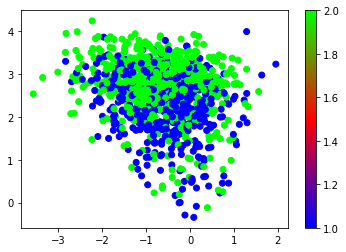

In [83]:
reuters2_test_latent_space, reuters2_test_decoded_labels, reuters2_train_latent_space, reuters2_train_decoded_labels = get_latent_space(
    train_data=reuters2_data_train_perm, 
    train_labels=reuters2_labels_train_one_hot_perm, 
    test_data=reuters2_data_test, 
    test_labels=reuters2_labels_test_one_hot, 
    encoder=reuters2_onehot_encoder
)
plt.scatter(reuters2_train_latent_space[:,0],reuters2_train_latent_space[:,1], c=reuters2_train_decoded_labels, cmap='brg')
plt.colorbar()

Saving logs to /tmp/class_vae/deep/04_05_2019/20190504171559
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 3]
self.y.shape [None, 3]
xy.shape [None, 2003]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 25
epoch: 0
Train accuracy 0.35287007689476013
epoch: 1
Train accuracy 0.35287007689476013
epoch: 2
Train accuracy 0.35287007689476013
epoch: 3
Train accuracy 0.35287007689476013
epoch: 4
Train accuracy 0.35287007689476013


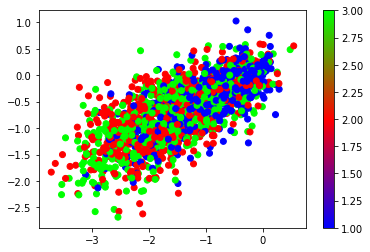

In [85]:
reuters3_test_latent_space, reuters3_test_decoded_labels, reuters3_train_latent_space, reuters3_train_decoded_labels = get_latent_space(
    train_data=reuters3_data_train_perm, 
    train_labels=reuters3_labels_train_one_hot_perm, 
    test_data=reuters3_data_test, 
    test_labels=reuters3_labels_test_one_hot, 
    encoder=reuters3_onehot_encoder
)
plt.scatter(reuters3_train_latent_space[:,0],reuters3_train_latent_space[:,1], c=reuters3_train_decoded_labels, cmap='brg')
plt.colorbar()

Saving logs to /tmp/class_vae/deep/04_05_2019/20190504171613
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 5]
self.y.shape [None, 5]
xy.shape [None, 2005]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 44
epoch: 0
Train accuracy 0.20793482661247253
epoch: 1
Train accuracy 0.2068721204996109
epoch: 2
Train accuracy 0.2068721204996109
epoch: 3
Train accuracy 0.2068721204996109
epoch: 4
Train accuracy 0.2068721204996109


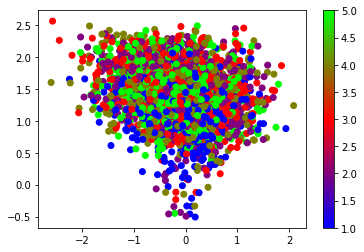

In [87]:
reuters5_test_latent_space, reuters5_test_decoded_labels, reuters5_train_latent_space, reuters5_train_decoded_labels = get_latent_space(
    train_data=reuters5_data_train_perm, 
    train_labels=reuters5_labels_train_one_hot_perm, 
    test_data=reuters5_data_test, 
    test_labels=reuters5_labels_test_one_hot, 
    encoder=reuters5_onehot_encoder
)
plt.scatter(reuters5_train_latent_space[:,0],reuters5_train_latent_space[:,1], c=reuters5_train_decoded_labels, cmap='brg')
plt.colorbar()

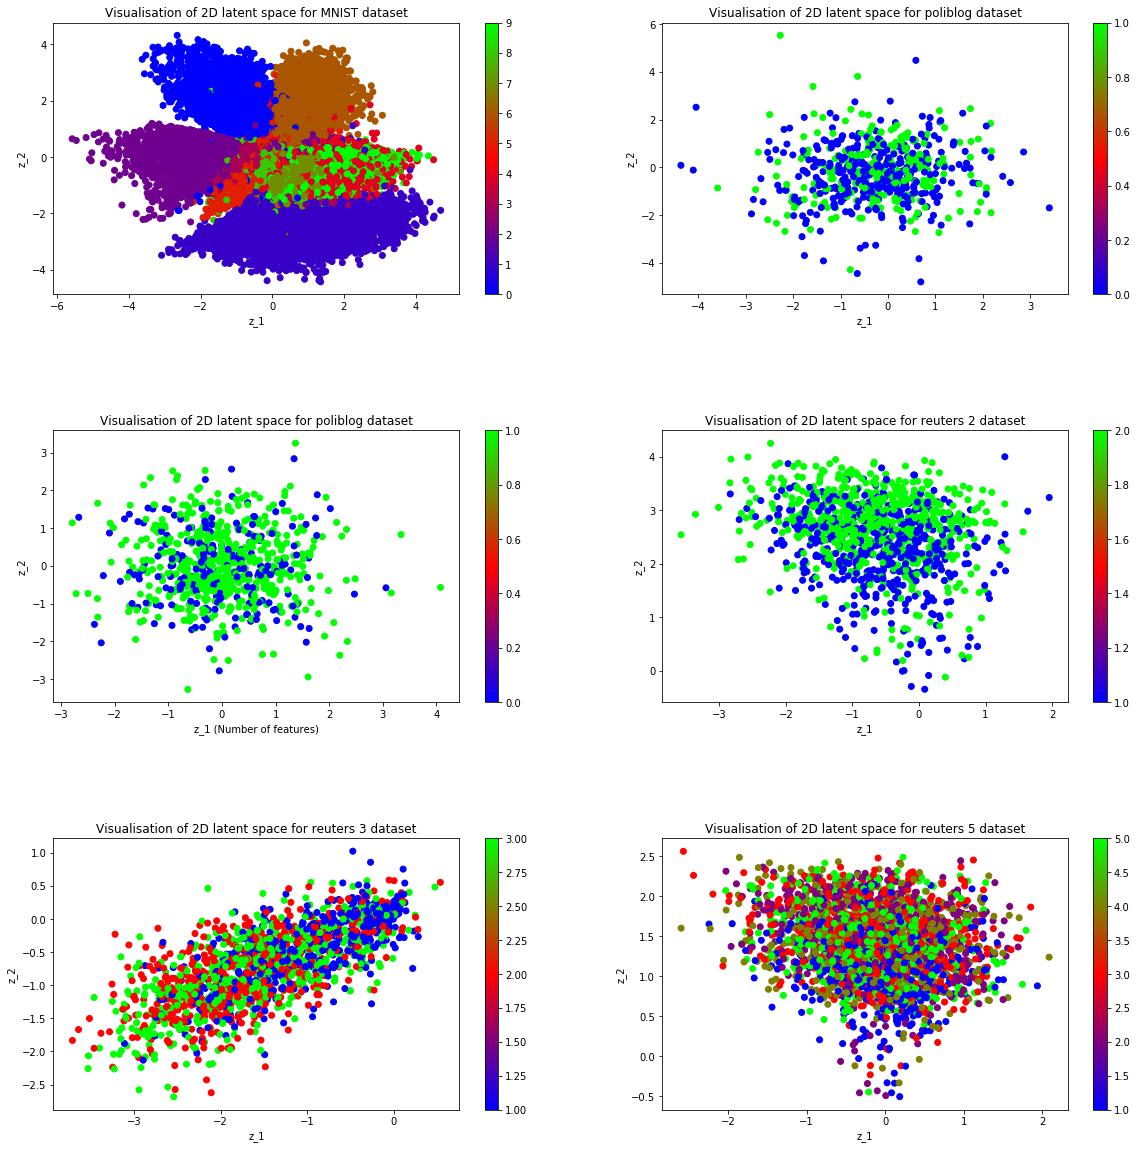

In [92]:
fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)

plt.subplot(3, 2, 1)
plt.scatter(mnist_train_latent_space[:,0],mnist_train_latent_space[:,1], c=mnist_train_decoded_labels, cmap='brg')
plt.colorbar()

plt.title("Visualisation of 2D latent space for MNIST dataset")
plt.xlabel("z_1")
plt.ylabel("z_2")

plt.subplot(3, 2, 2)
plt.scatter(poliblog_train_latent_space[:,0],poliblog_train_latent_space[:,1], c=poliblog_train_decoded_labels, cmap='brg')
plt.colorbar()

plt.title("Visualisation of 2D latent space for poliblog dataset")
plt.xlabel("z_1")
plt.ylabel("z_2")

plt.subplot(3, 2, 3)
plt.scatter(smsSpam_train_latent_space[:,0],smsSpam_train_latent_space[:,1], c=smsSpam_train_decoded_labels, cmap='brg')
plt.colorbar()

plt.title("Visualisation of 2D latent space for poliblog dataset")
plt.xlabel("z_1 (Number of features)")
plt.ylabel("z_2")

plt.subplot(3, 2, 4)
plt.scatter(reuters2_train_latent_space[:,0],reuters2_train_latent_space[:,1], c=reuters2_train_decoded_labels, cmap='brg')
plt.colorbar()

plt.title("Visualisation of 2D latent space for reuters 2 dataset")
plt.xlabel("z_1")
plt.ylabel("z_2")

plt.subplot(3, 2, 5)
plt.scatter(reuters3_train_latent_space[:,0],reuters3_train_latent_space[:,1], c=reuters3_train_decoded_labels, cmap='brg')
plt.colorbar()

plt.title("Visualisation of 2D latent space for reuters 3 dataset")
plt.xlabel("z_1")
plt.ylabel("z_2")

plt.subplot(3, 2, 6)
plt.scatter(reuters5_train_latent_space[:,0],reuters5_train_latent_space[:,1], c=reuters5_train_decoded_labels, cmap='brg')
plt.colorbar()

plt.title("Visualisation of 2D latent space for reuters 5 dataset")
plt.xlabel("z_1")
plt.ylabel("z_2")

plt.savefig('/Users/mjankowski/Desktop/vae_latent_space.png', bbox_inches='tight')
plt.show()